In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    for file in files:
        if "LSWMD" in file or "lswmd" in file:
            print(os.path.join(root, file))


/content/drive/MyDrive/datasets/LSWMD/LSWMD.pkl


In [3]:
# ================================
# FIX FOR OLD PANDAS PICKLE FILES
# ================================

import sys
import pandas as pd

# Monkey-patch missing pandas.indexes module
sys.modules['pandas.indexes'] = pd.core.indexes

print("✅ Pandas compatibility patch applied")
print("Pandas version:", pd.__version__)


✅ Pandas compatibility patch applied
Pandas version: 2.2.2


In [4]:
PKL_PATH = "/content/drive/MyDrive/datasets/LSWMD/LSWMD.pkl"


In [5]:
import pickle

with open(PKL_PATH, "rb") as f:
    data = pickle.load(f, encoding="latin1")

print("✅ LSWMD pickle loaded successfully")
print(type(data))
print(data.keys())


✅ LSWMD pickle loaded successfully
<class 'pandas.core.frame.DataFrame'>
Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType'],
      dtype='object')


In [6]:
# ==========================================
# LSWMD → IMAGE DATASET (ULTRA-SAFE VERSION)
# ==========================================

import os
import numpy as np
import cv2
from tqdm import tqdm

DATASET_DIR = "/content/Dataset"
os.makedirs(DATASET_DIR, exist_ok=True)

wafer_maps = data["waferMap"]
labels = data["failureType"]

valid_classes = ["Center", "Donut", "Edge", "Scratch", "Ring", "Random"]

# Create folders
for cls in valid_classes:
    os.makedirs(os.path.join(DATASET_DIR, cls), exist_ok=True)

count = {cls: 0 for cls in valid_classes}

def extract_label(label_arr):
    """
    Robustly extract string label from LSWMD failureType entry
    """
    try:
        # Convert numpy arrays / lists → string
        label = np.array(label_arr).flatten()[0]
        if isinstance(label, str):
            return label
        else:
            return None
    except:
        return None

for i in tqdm(range(len(wafer_maps))):

    label = extract_label(labels[i])
    if label not in valid_classes:
        continue

    wafer = np.nan_to_num(wafer_maps[i])

    if wafer.max() != 0:
        wafer = (wafer / wafer.max() * 255).astype(np.uint8)
    else:
        wafer = wafer.astype(np.uint8)

    wafer = cv2.resize(wafer, (224, 224))

    save_path = os.path.join(
        DATASET_DIR,
        label,
        f"{label}_{count[label]}.png"
    )

    cv2.imwrite(save_path, wafer)
    count[label] += 1

print("✅ Dataset conversion completed successfully")
print("Images per class:", count)


100%|██████████| 811457/811457 [00:10<00:00, 75222.04it/s]

✅ Dataset conversion completed successfully
Images per class: {'Center': 4294, 'Donut': 555, 'Edge': 0, 'Scratch': 1193, 'Ring': 0, 'Random': 866}


In [7]:
# Remove empty class folders
import os
import shutil

DATASET_DIR = "/content/Dataset"

for cls in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, cls)
    if len(os.listdir(class_path)) == 0:
        shutil.rmtree(class_path)
        print(f"Removed empty class: {cls}")


Removed empty class: Edge
Removed empty class: Ring


In [8]:
import os

DATASET_DIR = "/content/Dataset"
for cls in sorted(os.listdir(DATASET_DIR)):
    print(cls, "→", len(os.listdir(os.path.join(DATASET_DIR, cls))))


Center → 4294
Donut → 555
Random → 866
Scratch → 1193


TF: 2.19.0
Found 5528 images belonging to 4 classes.
Found 1380 images belonging to 4 classes.
Classes: ['Center', 'Donut', 'Random', 'Scratch']
Class weights: {0: np.float64(0.4022118742724098), 1: np.float64(3.1126126126126126), 2: np.float64(1.9942279942279941), 3: np.float64(1.4471204188481674)}
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.2608 - loss: 1.5789

173/173 ━━━━━━━━━━━━━━━━━━━━ 143s 645ms/step - accuracy: 0.2608 - loss: 1.5786 - val_accuracy: 0.0804 - val_loss: 1.4204 - learning_rate: 1.0000e-04
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.2468 - loss: 1.4808

173/173 ━━━━━━━━━━━━━━━━━━━━ 79s 455ms/step - accuracy: 0.2470 - loss: 1.4807 - val_accuracy: 0.2594 - val_loss: 1.3790 - learning_rate: 1.0000e-04
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 76s 440ms/step - accuracy: 0.2877 - loss: 1.4424 - val_accuracy: 0.2174 - val_loss: 1.3485 - learning_rate: 1.0000e-04
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 77s 447ms/step - accuracy: 0.2962 - loss: 1.3926 - val_accuracy: 0.2500 - val_loss: 1.2904 - learning_rate: 1.0000e-04
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 76s 440ms/step - accuracy: 0.2768 - loss: 1.3787 - val_accuracy: 0.2493 - val_loss: 1.2529 - learning_rate: 1.0000e-04
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 449ms/step - accuracy: 0.2886 - loss: 1.3911 - val_accuracy: 0.2348 - val_loss: 1.2407 - learning_rate: 1.0000e-04
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 77s 446ms/step - accuracy: 0.3386 - loss: 1.3388 - val_accuracy: 0.2420 - val_loss: 1.1971 - learning_rate: 1.0000e-04
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 448ms/step - 

173/173 ━━━━━━━━━━━━━━━━━━━━ 77s 448ms/step - accuracy: 0.3713 - loss: 1.2167 - val_accuracy: 0.2710 - val_loss: 1.0845 - learning_rate: 1.0000e-04
Epoch 18/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 452ms/step - accuracy: 0.3934 - loss: 1.1716 - val_accuracy: 0.2362 - val_loss: 1.0855 - learning_rate: 1.0000e-04
Epoch 19/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 76s 441ms/step - accuracy: 0.3573 - loss: 1.2078 - val_accuracy: 0.2413 - val_loss: 1.0943 - learning_rate: 1.0000e-04
Epoch 20/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 91s 526ms/step - accuracy: 0.3786 - loss: 1.2079 - val_accuracy: 0.2406 - val_loss: 1.0952 - learning_rate: 1.0000e-04
Epoch 21/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 76s 441ms/step - accuracy: 0.3691 - loss: 1.2054 - val_accuracy: 0.2442 - val_loss: 1.0840 - learning_rate: 3.0000e-05
Epoch 22/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 447ms/step - accuracy: 0.3966 - loss: 1.1888 - val_accuracy: 0.2442 - val_loss: 1.0876 - learning_rate: 3.0000e-05
Epoch 23/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 449ms/s

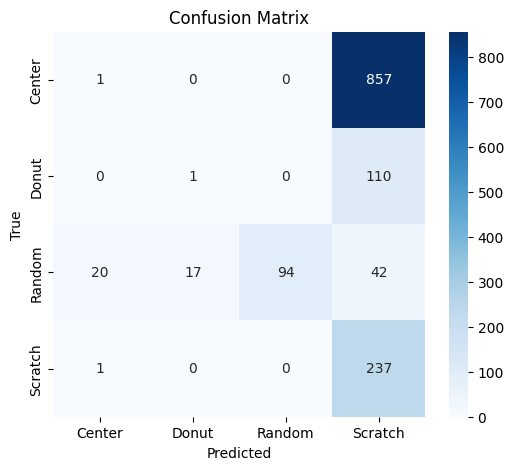

In [9]:
# =========================
# 1. IMPORTS
# =========================
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TF:", tf.__version__)

# =========================
# 2. CONFIG
# =========================
DATASET_DIR = "/content/Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
LR = 1e-4
MODEL_PATH = "/content/wafer_efficientnet_4class.h5"

# =========================
# 3. DATA GENERATORS
# =========================
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

val_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_ds = train_gen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_ds = val_gen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

NUM_CLASSES = train_ds.num_classes
CLASS_NAMES = list(train_ds.class_indices.keys())
print("Classes:", CLASS_NAMES)

# =========================
# 4. CLASS WEIGHTS
# =========================
labels = train_ds.classes
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# =========================
# 5. MODEL
# =========================
base = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
out = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(base.input, out)

model.compile(
    optimizer=Adam(LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# =========================
# 6. CALLBACKS
# =========================
cbs = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3, min_lr=1e-6),
    ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor="val_accuracy")
]

# =========================
# 7. TRAIN
# =========================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=cbs
)

# =========================
# 8. EVALUATION
# =========================
val_ds.reset()
pred = model.predict(val_ds)
y_pred = np.argmax(pred, axis=1)
y_true = val_ds.classes

print("\nClassification Report\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [11]:
# =========================
# FINE-TUNING
# =========================

from tensorflow.keras.optimizers import Adam

# Unfreezing fewer EfficientNet layers (faster, safer)
for layer in model.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 3,487,264 (13.30 MB)

 Non-trainable params: 896,391 (3.42 MB)

NameError: name 'callbacks' is not defined

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

MODEL_PATH = "/content/drive/MyDrive/wafer_efficientnet_4class.h5"

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        MODEL_PATH,
        monitor="val_accuracy",
        save_best_only=True
    )
]

print("callbacks ready")


callbacks ready


In [13]:
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.2961 - loss: 2.1812

173/173 ━━━━━━━━━━━━━━━━━━━━ 151s 638ms/step - accuracy: 0.2963 - loss: 2.1796 - val_accuracy: 0.1254 - val_loss: 3.5573 - learning_rate: 1.0000e-05
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 79s 458ms/step - accuracy: 0.3515 - loss: 1.6487 - val_accuracy: 0.1254 - val_loss: 2.5346 - learning_rate: 1.0000e-05
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.3855 - loss: 1.4395

173/173 ━━━━━━━━━━━━━━━━━━━━ 80s 462ms/step - accuracy: 0.3855 - loss: 1.4393 - val_accuracy: 0.3464 - val_loss: 1.2957 - learning_rate: 1.0000e-05
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 79s 457ms/step - accuracy: 0.4054 - loss: 1.3350 - val_accuracy: 0.1768 - val_loss: 1.6461 - learning_rate: 1.0000e-05
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 79s 454ms/step - accuracy: 0.4236 - loss: 1.2665 - val_accuracy: 0.1812 - val_loss: 1.4605 - learning_rate: 1.0000e-05
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 449ms/step - accuracy: 0.4415 - loss: 1.1789 - val_accuracy: 0.1870 - val_loss: 1.7541 - learning_rate: 1.0000e-05
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 451ms/step - accuracy: 0.4413 - loss: 1.1454 - val_accuracy: 0.1920 - val_loss: 1.6713 - learning_rate: 3.0000e-06
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 79s 457ms/step - accuracy: 0.4659 - loss: 1.1104 - val_accuracy: 0.1978 - val_loss: 1.7521 - learning_rate: 3.0000e-06


In [15]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True

)


In [16]:
class_weights = {
    0: 1.0,   # Center
    1: 1.5,   # Donut (reduced)
    2: 1.0,   # Scratch
    3: 1.0    # Random
}


In [17]:
for layer in model.layers[-20:]:
    layer.trainable = True


In [18]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=3e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 163s 688ms/step - accuracy: 0.4618 - loss: 1.3894 - val_accuracy: 0.1833 - val_loss: 1.2829 - learning_rate: 3.0000e-06
Epoch 2/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - accuracy: 0.5226 - loss: 1.2601 - val_accuracy: 0.1855 - val_loss: 1.3307 - learning_rate: 3.0000e-06
Epoch 3/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 81s 466ms/step - accuracy: 0.5809 - loss: 1.1343 - val_accuracy: 0.1841 - val_loss: 1.3240 - learning_rate: 3.0000e-06
Epoch 4/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 81s 467ms/step - accuracy: 0.5995 - loss: 1.1413 - val_accuracy: 0.2333 - val_loss: 1.2054 - learning_rate: 3.0000e-06
Epoch 5/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 451ms/step - accuracy: 0.5923 - loss: 1.1429 - val_accuracy: 0.2942 - val_loss: 1.1578 - learning_rate: 3.0000e-06
Epoch 6/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 84s 488ms/step - accuracy: 0.5998 - loss: 1.1257 - val_accuracy: 0.1775 - val_loss: 1.4715 - learning_rate: 3.0000e-06
Epoch 7/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 80s 459ms/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step
              precision    recall  f1-score   support

      Center       0.59      0.17      0.27       858
       Donut       0.11      0.94      0.19       111
      Random       0.94      0.88      0.91       173
     Scratch       0.00      0.00      0.00       238

    accuracy                           0.29      1380
   macro avg       0.41      0.50      0.34      1380
weighted avg       0.49      0.29      0.30      1380



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


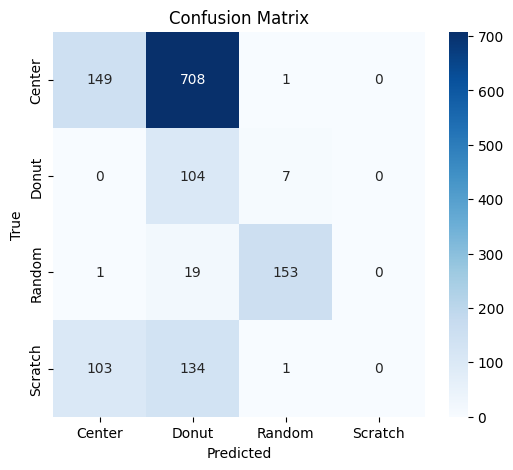

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

val_ds.reset()
pred = model.predict(val_ds)
y_pred = np.argmax(pred, axis=1)
y_true = val_ds.classes
class_names = list(val_ds.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [21]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Last convolutional layer in EfficientNetB0
last_conv_layer_name = "top_activation"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [24]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img_array])
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


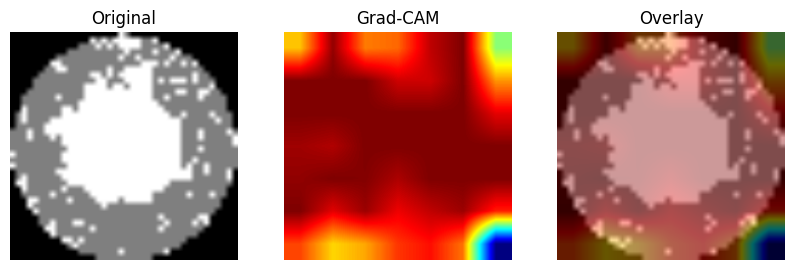

In [25]:
# Pick one validation image
img_path = val_ds.filepaths[10]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224,224))
img_array = np.expand_dims(img_resized / 255.0, axis=0)

heatmap = make_gradcam_heatmap(img_array, model, "top_activation")

heatmap = cv2.resize(heatmap, (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed = cv2.addWeighted(img_resized, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_resized)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(superimposed)
plt.axis("off")

plt.show()
